# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A3 - AUTOENCODERS**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 11/03/2024**
- **Fecha de Entrega: 17/03/2024**
- **Test: 18/03/2024**


In [2]:
import tensorflow as tf 
import warnings
warnings.filterwarnings('ignore')

# * Data manipulation 
import pandas as pd 
import numpy as np 
import os 

# * Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# * Scikit learn 
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE 

# * Keras 
from keras import layers 
from keras.layers import Input, Dense 
from keras.models import Model, Sequential 
from keras import regularizers

# Carga de datos

Vamos a usar los autoencoders para tratar de predecir si un pago con una tarjeta es un pago fraudulento. Para ello, usaremos un dataset de datos reales en el que por cuestiones de confidencialidad se han aplicado transformaciones a los campos. En concreto, se han tomado 29 características y se les ha aplicado un PCA. De esta forma, no es posible saber cuál es el significado de cada una de ellas.

La columna Class del dataset indica si es un pago fradulento (1) o si no lo es (0).

El dataset se puede descargar desde el siguiente enlace: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#pd_data = pd.read_csv("/content/drive/MyDrive/data/creditcard.csv").drop(columns=["Time"])
#pd_data
pd_data = pd.read_csv('creditcard.csv').drop(columns=["Time"])
pd_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Exploratorio
Realice un exploratorio simple de las features. Céntrese en la columna "Amount" que no ha sido tranformada y el target de la columna "Class".

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

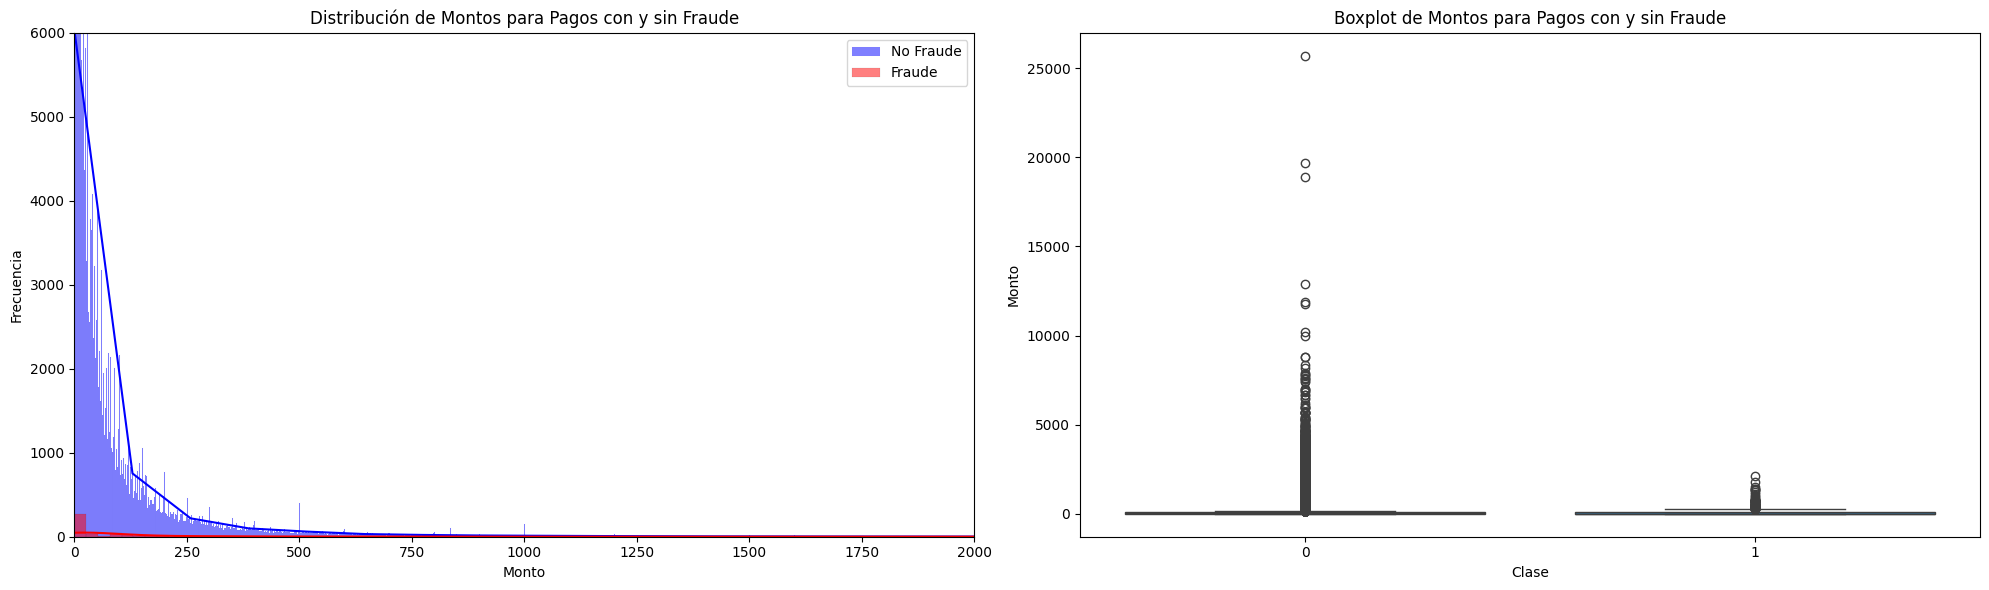

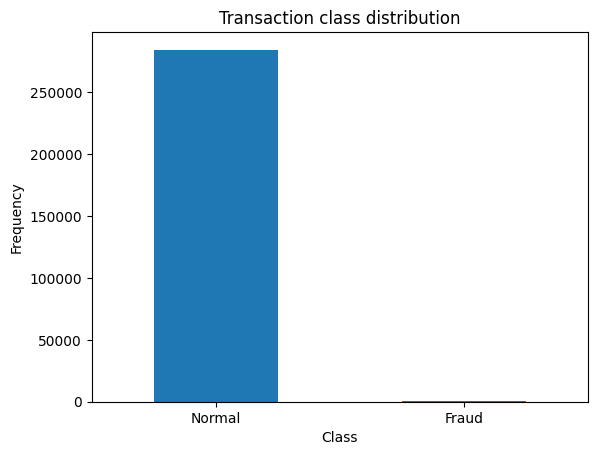

In [7]:
print(f"Dataset information: {pd_data.info()}\n\n")
print(f"Dataset description:{pd_data.describe()}\n\n")
print(f"Dataset Null Values? {pd_data.isnull().values.any()}\n\n")
 # * Estadísticas descriptivas para la columna "Amount"
print(pd_data['Amount'].describe())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# * Histograma para la distribución de "Amount" por clase
sns.histplot(pd_data[pd_data['Class'] == 0]['Amount'], ax=axes[0], color='blue', kde=True, label='No Fraude')
sns.histplot(pd_data[pd_data['Class'] == 1]['Amount'], ax=axes[0], color='red', kde=True, label='Fraude')
max_frequency = 6000
axes[0].set_ylim(0, max_frequency)
axes[0].set_xlim(0, 2000)
axes[0].set_title('Distribución de Montos para Pagos con y sin Fraude')
axes[0].set_xlabel('Monto')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# * Boxplot para la distribución de "Amount" por clase
sns.boxplot(x='Class', y='Amount', data=pd_data, ax=axes[1])
axes[1].set_title('Boxplot de Montos para Pagos con y sin Fraude')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Monto')

# Mostrar la figura con ambos subplots
plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
plt.show()

count_classes = pd.value_counts(pd_data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


# Preprocesado

Aplique una normalización para que las features estén en el intervalo 0 a 1. Además, divida el dataset en train y test.

In [9]:
 # * Copiamos el dataset original para manipularlo 
pd_data_pr = pd_data.copy()
genuine_trx = pd_data_pr[pd_data_pr['Class'] == 0]
fraud_trx = pd_data_pr[pd_data_pr['Class'] == 1] 
print(f"Features - Frauds: {fraud_trx.shape} - Genuine: {genuine_trx.shape}")

Features - Frauds: (492, 30) - Genuine: (284315, 30)


In [12]:
 # ! - Definimos el scaler apropiado para que los valores no salgan del rango definido
scaler = MinMaxScaler(feature_range=(0,1))
pd_data_pr.iloc[:, :-1] = scaler.fit_transform(pd_data_pr.iloc[:, :-1]) # * Al no incluir la variable del tiempo, normalizamos todo salvo la clase
pd_data_pr

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.863749,0.528729,0.598850,...,0.564920,0.515249,0.680500,0.313600,0.658558,0.466291,0.433929,0.329840,0.000030,0
284803,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.788548,0.482925,0.488530,...,0.564933,0.553153,0.665619,0.245298,0.543855,0.360884,0.417775,0.312038,0.000965,0
284804,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.792985,0.477677,0.498692,...,0.565220,0.537005,0.664877,0.468492,0.592824,0.411177,0.416593,0.312585,0.002642,0
284805,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.792671,0.476287,0.500464,...,0.565755,0.547353,0.663008,0.398836,0.545958,0.514746,0.418520,0.315245,0.000389,0


In [63]:
 # ! - Ahora se nos pide que dividamos el dataset en train y test, pero en el siguiente enunciado especifica que debemos de 
 # ! - construir un mecanismo para la detección de anomalías. Por ello, nuestro training data, solo deben de contener aquellos pagos genuinos
X_train, X_test = train_test_split(pd_data_pr, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

# Auto encoder

Se requiere construir un mecanismo para la detección de anomalías con un autoencoder. Vamos a considerar que los pagos fraudulentos son poco comunes y tienen algunas características especiales que no tienen el resto de pagos.

## Creación del modelo

Cree un autoencoder con encoder y decoder simétricos. Dos capas en cada uno serán suficientes, y tome como dimensión del Latent un valor entre 4 y 10.

Atención a la función de activación de la última capa del decoder!!!

In [64]:
 # * Definimos la dimensión de nuestras entradas y del espacio latente
input_dim = X_train.shape[1]  # * Número de características
latent_dim = 8  # * Dimensión del espacio latente

# * Definimos el encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='tanh')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)

# * Definimos el decoder
decoded = Dense(16, activation='tanh')(encoded)

# * Capa de salida: 
output_layer = Dense(input_dim, activation='sigmoid')(decoded) # ? - usamos 'sigmoid' para asegurar que la salida esté en el rango [0, 1]

# * Creamos el modelo de autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Entrenamiento

Entrene el modelo hasta alcanzar la convergencia necesaria para la detección de anomalías.

In [65]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test)).history

Epoch 1/100


7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step - accuracy: 0.9534 - loss: 0.5954 - val_accuracy: 0.9913 - val_loss: 0.5889
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step - accuracy: 0.9917 - loss: 0.5887 - val_accuracy: 0.9883 - val_loss: 0.5885
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 475us/step - accuracy: 0.9888 - loss: 0.5884 - val_accuracy: 0.9890 - val_loss: 0.5884
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 460us/step - accuracy: 0.9885 - loss: 0.5883 - val_accuracy: 0.9869 - val_loss: 0.5884
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step - accuracy: 0.9898 - loss: 0.5883 - val_accuracy: 0.9897 - val_loss: 0.5883
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 454us/step - accuracy: 0.9915 - loss: 0.5882 - val_accuracy: 0.9905 - val_loss: 0.5883
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step - accuracy: 0.9921 - loss: 0.5882 - val_accuracy: 0.9914 - val_loss: 0.5883
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step - accuracy: 0.9927 - los

2024-03-15 13:19:37.589956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Expected tensor of type int32 but got type float
	 [[{{function_node __inference_one_step_on_data_6250181}}{{node Equal}}]]


InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/ytobio/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_22410/3048513639.py", line 1, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 76, in train_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 375, in compute_metrics

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 331, in update_state

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 18, in update_state

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/metrics/reduction_metrics.py", line 199, in update_state

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/metrics/accuracy_metrics.py", line 166, in categorical_accuracy

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 2464, in equal

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 770, in equal

Expected tensor of type int32 but got type float
	 [[{{node Equal}}]] [Op:__inference_one_step_on_iterator_6250246]

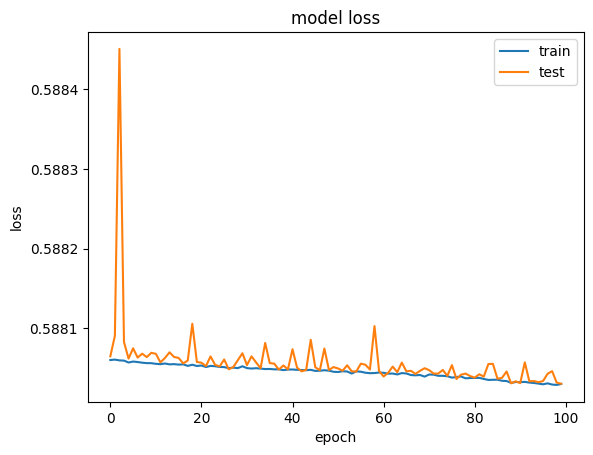

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Análisis de error de reconstrucción
Calcule el error cuadrático medio entre cada una de las muestras del dataset de train y la reconstrucción pasando por el autoencoder. Dibuje el histograma del error en los pagos fraudulentos y en los normales por separado, y en una misma gráfica. Comente los resultados.

In [ ]:
# * Al haber solo entrenado el modelo con los pagos verdaderos, con el objetivo de afinarlos hacia la detección de outliers, no habrá error
# * para errores fraudulentos. 
# * Hacemos las predicciones para los outliers - Pagos fraudes y sacamos su MSE
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)

# Creamos un DataFrame para facilitar el análisis
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})
error_df.describe()

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 230us/step


,reconstruction_error,true_class
count,227451.000000,227451.0
mean,0.049108,0.0
std,0.002150,0.0
min,0.016146,0.0
25%,0.047790,0.0
50%,0.048911,0.0
75%,0.050275,0.0
max,0.149128,0.0


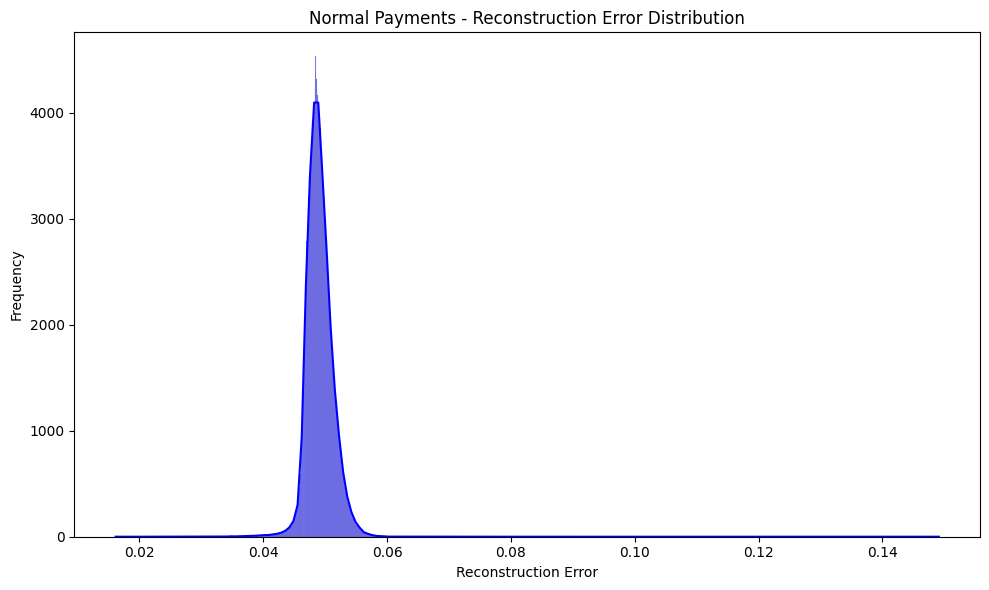

In [ ]:
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]
fraud_error_df = error_df[error_df['true_class'] == 1]

# Create a figure with two subplots side by side
plt.figure(figsize=(10,6))
sns.histplot(error_df['reconstruction_error'], color='blue', kde = True)
plt.title('Normal Payments - Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Elección del threshold
Vamos a tratar de elegir un buen valor de threshold del error para decidir si es un pago fradulento o no lo es. Para ello, tome unos 100 valores en el rango que toma el threshold y calcule sobre el dataset de train la precisión, el recall, el false positive rate y el true positive rate. Pinte cada uno de ellos en una gráfica (el eje x es el posible valor del threshold).

In [67]:
def false_positive_rate(y, y_pred):
    """y is 0, y_pred is 1"""
    return sum( (1- y) * y_pred) / sum(1-y)
def true_positive_rate(y, y_pred):
    """both are one"""
    return sum(y * y_pred) / sum(y)

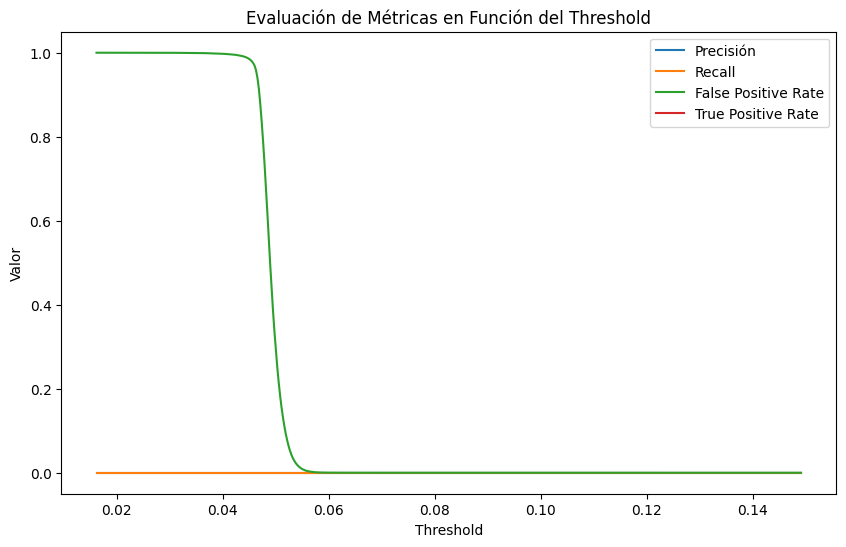

In [68]:
threshold_values = np.linspace(min(mse), max(mse), 500)
precision_values = []
recall_values = []
fpr_values = []
tpr_values = []

# Loop through each threshold value to calculate metrics
for threshold in threshold_values:
    # Label predictions based on the threshold
    predictions = (error_df['reconstruction_error'] > threshold).astype(int)

    # Calculate precision and recall using built-in functions
    precision = precision_score(error_df['true_class'], predictions)
    recall = recall_score(error_df['true_class'], predictions)

    # Use your custom functions for FPR and TPR
    fpr = false_positive_rate(error_df['true_class'].values, predictions.values)
    tpr = true_positive_rate(error_df['true_class'].values, predictions.values)

    # Store the metric values
    precision_values.append(precision)
    recall_values.append(recall)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

# Plot metrics as a function of threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, precision_values, label='Precisión')
plt.plot(threshold_values, recall_values, label='Recall')
plt.plot(threshold_values, fpr_values, label='False Positive Rate')
plt.plot(threshold_values, tpr_values, label='True Positive Rate')
plt.title('Evaluación de Métricas en Función del Threshold')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.legend()
plt.show()


## Evaluación en test
Tomando un valor del threshold que considere adecuado, calcule la precisión, el recall, el false positive rate y el true positive rate sobre el dataset de test.

In [ ]:
 # * Hacemos las predicciones para los outliers - Pagos fraudes y sacamos su MSE
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Creamos un DataFrame para facilitar el análisis
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

# Sparse AutoEncoder

## Creación del modelo
Repitamos todo el proceso pero usando un sparse autoencoder. Solamente añada regularización l1 en la última capa del encoder. Además, puede probar a aumentar un poco la dimensión del encoding.

## Entrenamiento

## Análisis de error de reconstrucción
Calcule el error cuadrático medio entre cada una de las muestras del dataset de train y la reconstrucción pasando por el autoencoder. Dibuje el histograma del error en los pagos fraudulentos y en los normales por separado en una misma gráfica. Comente los resultados.

## Elección del threshold
Calcule las mismas métricas de antes en función del threshold. Pinte en la misma gráfica la curva del autoencoder y la del sparse autoencoder. ¿Cuál funciona mejor?

## Evaluación en test
Tomando un valor del threshold que considere adecuado, calcule la precisión, el recall, el false positive rate y el true positive rate sobre el dataset de test.

# Elección del threshold en base a un Caso de Uso
En este apartado tome la versión del autoencoder que haya dado mejores resultados.

Planteemos el siguiente Caso de Uso:

Cuando detectamos que un pago puede ser fraudulento, podemos hacer una llamada al cliente para que confirme que ha sido él quien ha realizado el pago; en este caso estimamos el coste de la llamada en 50 céntimos.
También podemos confiar en que el cliente posteriormente nos llame para notificar el fraude y cancelar el pago; en este caso, se realiza una gestión más cara que estimamos en unos 2 euros.

¿Cuál debería ser el threshold para minimizar el coste? Explique el razonamiento.

In [ ]:
COST_CALL = 0.5
COST_CANCELATION = 2

# Conclusiones del estudio

Detallar las principales conclusiones extraidas sobre la construcción del modelo Autoencoder, la comparativa entre modelos y su aplicación en sistemas de detección de anomalías.

*Escribir AQUI las conclusiones*